In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [124]:
def parse_fn(subfolder,file):
    """
    Reads the jpe image as well as the intrinsic matrix file
    """
    img_str = tf.read_file(tf.strings.join([folder,subfolder,file+'.jpg'],'/'))
    intrinsics = tf.read_file(tf.strings.join([folder,subfolder,file+'_cam.txt'],'/'))
    
    intrinsics = tf.string_split([intrinsics],',').values
    intrinsics = tf.string_to_number(intrinsics)
    intrinsics = tf.reshape(intrinsics, [3,3])
    
    img = tf.image.decode_jpeg(img_str,channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_images(img, [128, 1248])
    
    return img,intrinsics,[subfolder,file]

def scale_intrinsics_fn(frames,intrinsics,data):
    # TODO
    return frames,intrinsics,data

def separate_fn(frames,intrinsics,data,num_source):
    img_width = int(frames.shape[1]//(num_source+1))
    img_height= frames.shape[0]
    
    # Target frame
    target = tf.slice(
        frames,
        [0,img_width*(num_source//2),0],
        [-1,img_width,-1])
    
    # Source frames
    src1 = tf.slice(
        frames,
        [0,0,0],
        [-1,img_width,-1])
    src2 = tf.slice(
        frames,
        [0,2*img_width,0],
        [-1,img_width,-1])
    
    # The order is to allow random changes in images easier
    frames = tf.concat([src1,src2,target],axis=2)
    frames.set_shape([img_height,img_width,3*(num_sources+1)])
    return frames,intrinsics,data

def separate_target_fn(frames,intrinsics,data):
    """
    Returns the target frame, source frames and intrisics.
    We asume the target is at last in the color channel
    """
    img_height,img_width,c = frames.shape
    
    # Target frame
    target = tf.slice(
        frames,
        [0,0,tf.cast(c-3,tf.int32)],
        [-1,-1,3])
    
    # Source frames
    srcs = tf.slice(
        frames,
        [0,0,0],
        [-1,-1,6])
    
    return target,srcs,intrinsics,data
    

def data_augmentation(img,intrinsics,data):
    img_height,img_width,_ = img.get_shape().as_list()

    
    # Random scaling
    def random_scaling(img, intrinsics):
        scaling = tf.random_uniform([2], 1, 1.15)
        x_scaling = scaling[0]
        y_scaling = scaling[1]
        
        new_h = tf.cast(img_height * y_scaling, dtype=tf.int32)
        new_w = tf.cast(img_width  * x_scaling, dtype=tf.int32)
        
        #img = tf.reshape(img,[1,img_height,img_width,9])
        #img = tf.image.resize_area(img, [new_h, new_w])
        img = tf.image.resize_images(img,[new_h,new_w])
        #img = img.set_shape([new_h,new_w,9])
       # img = tf.squeeze(img,axis=0)
        
        intrinsics[0*3+0] *= x_scaling # fx
        intrinsics[1*3+1] *= y_scaling # fy
        intrinsics[0*3+2] *= x_scaling # cx
        intrinsics[1*3+2] *= y_scaling # cy
        
        return img, intrinsics
    
    # Random cropping
    def random_cropping(img,intrinsics):
        #new_h, new_w,_ = img.get_shape()
        new_h = tf.shape(img)[0]
        new_w = tf.shape(img)[1]
                        
        offset_y = tf.random_uniform([1], 0, new_h - img_height + 1, dtype=tf.int32)[0]
        offset_x = tf.random_uniform([1], 0, new_w - img_width  + 1, dtype=tf.int32)[0]
        
        img = tf.image.crop_to_bounding_box(
            img, offset_y, offset_x, img_height, img_width)

        intrinsics[0*3+2] -= tf.cast(offset_x, dtype=tf.float32) # cx
        intrinsics[1*3+2] -= tf.cast(offset_y, dtype=tf.float32) # cy
        
        return img, intrinsics
    
    intrinsics = tf.unstack(tf.reshape(intrinsics,[-1]))
    
    img,intrinsics = random_scaling(img,intrinsics)
    img,intrinsics = random_cropping(img,intrinsics)
    img = tf.cast(img, dtype=tf.float32)
    
    intrinsics = tf.stack(intrinsics)
    intrinsics = tf.reshape(intrinsics,[3,3])
        
    return img, intrinsics, data

In [139]:
batch_size = 1
num_parallel = 4
num_sources = 2 # Number of sources
seed = 1
folder = "/HDD/Documents/SfMLearner_data/"

"""
Returns an element. Running sess.run(element) will return a list
of bath_size points, each containing their corresponding 
target, sources, intrinsic matrix and data. Data Contains
the subfolder of the frames and the number of the frames.
Data is not used in training and can be ignored.
"""

# f,i,d stands for Frame, Intrinsics, Data
imgs = tf.data.TextLineDataset(os.path.join(folder,"train.txt"))
imgs = imgs.map(lambda string: tf.string_split([string]).values)
imgs = imgs.shuffle(100000000, seed=seed) # Big enought to cover all data points
imgs = imgs.map(lambda d : parse_fn(d[0],d[1]), num_parallel_calls=num_parallel)
imgs = imgs.map(lambda f,i,d : scale_intrinsics_fn(f,i,d), num_parallel_calls=num_parallel)
imgs = imgs.map(lambda f,i,d : separate_fn(f,i,d,num_sources), num_parallel_calls=num_parallel)
imgs = imgs.map(lambda f,i,d : data_augmentation(f,i,d), num_parallel_calls=num_parallel)
imgs = imgs.map(lambda f,i,d : separate_target_fn(f,i,d), num_parallel_calls=num_parallel)
imgs = imgs.batch(batch_size)


iterator = imgs.make_initializable_iterator()
elem = iterator.get_next()

[[b'2011_10_03_drive_0034_sync_03' b'0000003635']]


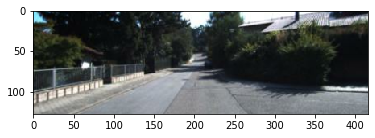

[[b'2011_10_03_drive_0034_sync_03' b'0000002855']]


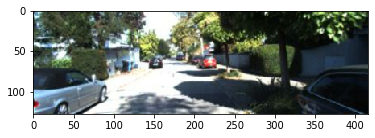

[[b'2011_10_03_drive_0034_sync_03' b'0000004005']]


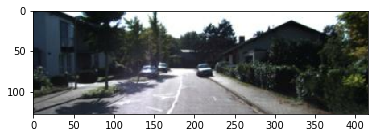

[[b'2011_09_30_drive_0028_sync_03' b'0000001577']]


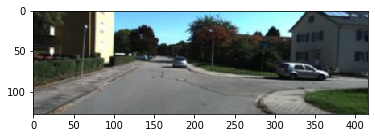

[[b'2011_10_03_drive_0034_sync_02' b'0000004079']]


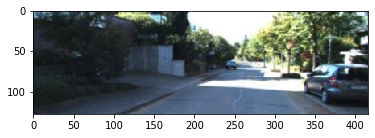

In [153]:
with tf.Session() as sess:
    sess.run(iterator.initializer)
    for _ in range(5):
        t,s,i,d = sess.run(elem)
        print(d)
        plt.imshow(t[0])
        plt.show()

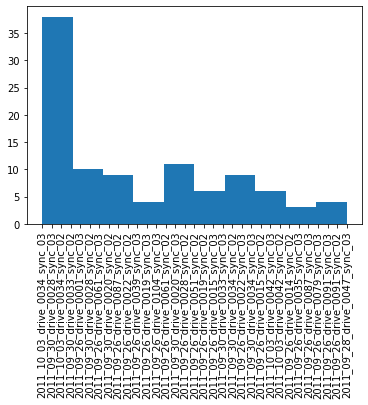

In [152]:
# Checks if the distribution of the folders follow 
# the distribution of number of files in the dataset
# You should expect a pick for: 
# - 2011_09_30_drive_0028_sync_03
# - 2011_09_30_drive_0028_sync_02
# - 2011_10_03_drive_0034_sync_03
# - 2011_10_03_drive_0034_sync_02

hist = [] 
with tf.Session() as sess:
    sess.run(iterator.initializer)
    for _ in range(100):
        t,s,i,d = sess.run(elem)
        hist.append(d[0][0])
plt.hist(hist)
plt.xticks(rotation=90);